# Семинар №3
Логистическая регрессия

Автор Д.В.Яценко

In [6]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

## Датасеты

### Ирисы

In [7]:
# блок подготовки данных
iris = load_iris()
X = iris.data 
Y = iris.target
Y = (Y > 0).astype(int)*2-1 # [0,1,2] --> [False,True,True] --> [0,1,1] --> [0,2,2] --> [-1,1,1]

### Продажи автомобилей

In [ ]:
import pandas as pd
X_all = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data", \
                    header=None, na_values=["?"])
X_all=X_all.dropna(axis=0)
Y = X_all[25].values
Y = (Y > np.average(Y)).astype(int)*2-1 # [0,1,2] --> [False,True,True] --> [0,1,1] --> [0,2,2] --> [-1,1,1]
X_raw = X_all.drop(25, axis=1)
print(X_raw.shape)
cat_features_mask = (X_raw.dtypes == "object").values 
X_real = X_raw[X_raw.columns[~cat_features_mask]]
from sklearn.impute import SimpleImputer
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), index=X_real.index, columns=X_real.columns)
# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
# print(X_dum.shape)
X=X_dum.values

### Вероятность инсульта

In [ ]:
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?select=healthcare-dataset-stroke-data.csv
import pandas as pd
X_all = pd.read_csv("healthcare-dataset-stroke-data.csv", \
                    na_values=["N/A","Unknown"])
X_stroke=X_all[X_all["stroke"]==1].dropna()
X_nostroke=X_all[X_all["stroke"]==0].dropna().sample(n = X_stroke.shape[0])
X_all=pd.concat([X_stroke, X_nostroke])
# X_all = X_all.apply(lambda x:  x.astype(str).str.lower())
Y = X_all['stroke'].values
Y = Y *2-1
X_raw = X_all.drop('stroke', axis=1).drop('id', axis=1)

cat_features_mask = (X_raw.dtypes == "object").values 
X_real = X_raw[X_raw.columns[~cat_features_mask]]
from sklearn.impute import SimpleImputer
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), index=X_real.index, columns=X_real.columns)
# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
# print(X_dum.shape)
X=X_dum.values

## Анализ датасета

In [9]:
# Уменьшаем размерность данных
pca = PCA(n_components=2)
X = pca.fit_transform(X)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

рисуем обучаюший датасет

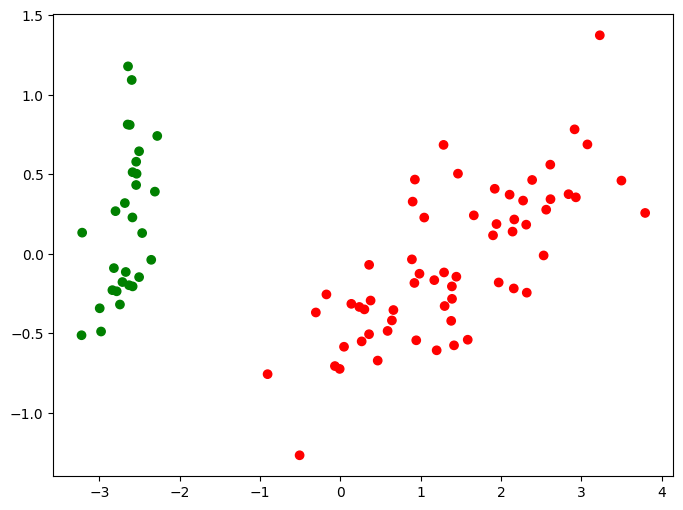

In [14]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in y_train])

рисуем тестовый датасет

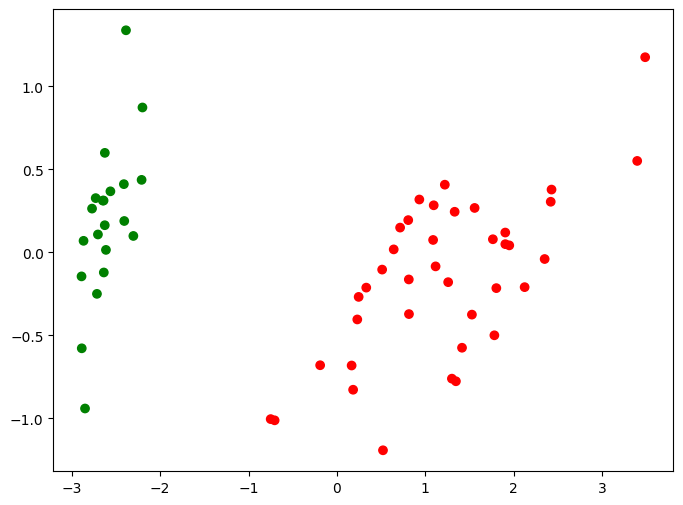

In [15]:
d = {-1:'green', 1:'red'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d[y] for y in y_test])

## Байесовый классификатор

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
baes_model = GaussianNB()
baes_model.fit(X_train, y_train)


GaussianNB()

In [17]:
nb_test_log_proba = baes_model.predict_log_proba(X_test) # log-probability estimates for X_test
nb_test_log_proba = np.argmax(nb_test_log_proba,axis=1)*2-1
baes_model.score(X_test, y_test)

1.0

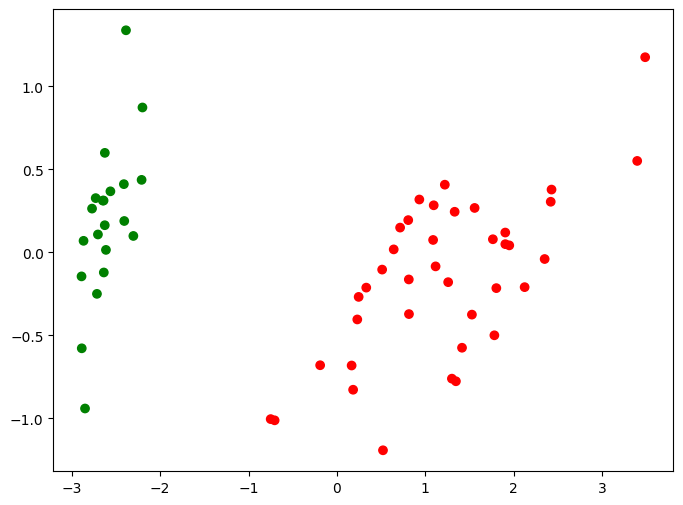

In [18]:
d = {-1:'green', 1:'red'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d[y] for y in y_test])
X_=X_test[nb_test_log_proba!=y_test]
plt.scatter(X_[:,0], X_[:,1], c='black',marker='x')
#print(nb_test_log_proba,y_test)

## KNN классификатор

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [20]:
knn_test_proba = knn_model.predict_proba(X_test) # 
knn_test_proba = np.argmax(knn_test_proba,axis=1)*2-1
knn_model.score(X_test, y_test)

1.0

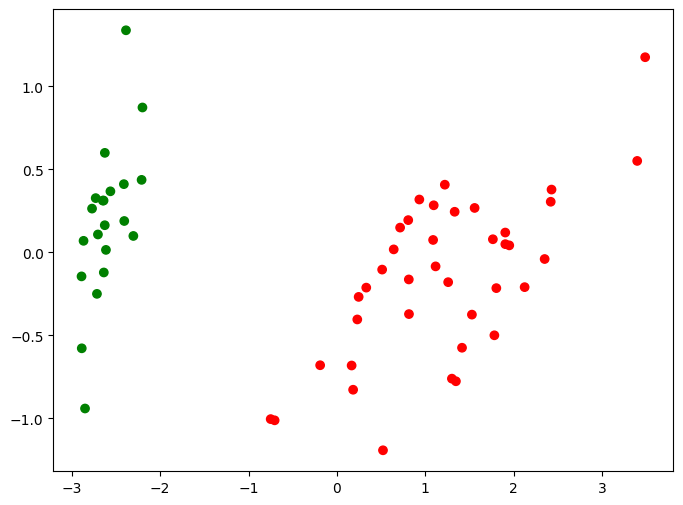

In [21]:
d = {-1:'green', 1:'red'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d[y] for y in y_test])
X_=X_test[knn_test_proba!=y_test]
plt.scatter(X_[:,0], X_[:,1], c='black',marker='x')
#print(knn_test_proba,y_test)

## Логистическая регрессия

In [22]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

In [37]:
lr=0.00001
w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1]+1)

def grad_loss_sigm(M,X,y):
    return -np.exp(-M)/(1+np.exp(-M))*y*X 
def grad_loss_hinge(M,X,y):
    return 0 if M>1 else -y*X 
def grad_loss_square(M,X,y):
    return 0 if M>1 else -2*(1-M)*y*X 
for epoch in range(100):
    for i,x in enumerate(add_bias_feature(X_train)):
        margin = y_train[i]*np.dot(x,w)
        w=w-lr*grad_loss_square(margin,x,y_train[i]) ##

In [38]:
regr_test_proba = np.array([])
for i,x in enumerate(add_bias_feature(X_test)):
    regr_test_proba=np.append(regr_test_proba, x.T@ w)

In [39]:
(y_test == np.sign(regr_test_proba)).sum()/len(y_test)
#np.rint(1/(1 + np.exp(regr_test_proba)))*2-1,y_test

0.95

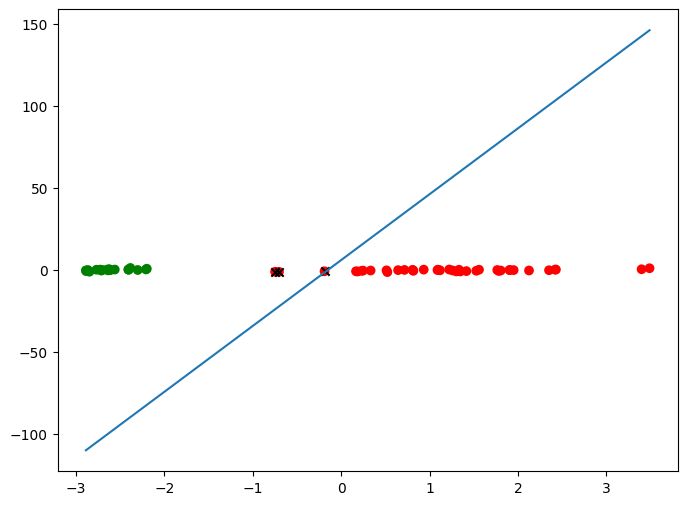

In [40]:
regr_test_proba=np.sign(regr_test_proba)
d = {-1:'green', 1:'red'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d[y] for y in y_test])
X_=X_test[regr_test_proba!=y_test]
plt.scatter(X_[:,0], X_[:,1], c='black',marker='x')
a=min(X_test[:,0])
b=max(X_test[:,0])     
A=np.array([a,b])
B=np.array([-a*w[0]/w[1]-w[2]/w[1],-b*w[0]/w[1]-w[2]/w[1]])
plt.plot(A,B)
#print(regr_test_proba,y_test)

In [27]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

In [28]:
clf.score(X_test, y_test)

1.0